# 基于随机森林模型（RandomForest）的心脏病人预测分类

<a id='section1'></a>

# 背景

在机器学习的所有应用中，使用黑匣子诊断任何严重疾病总是很难的。如果模型的输出是特定的治疗过程（可能有副作用）、手术或是否有疗效，人们会想知道为什么。

该数据集提供了许多变量以及患有或不患有心脏病的目标条件。下面，数据首先用于一个简单的随机森林模型，然后使用 ML 可解释性工具和技术对该模型进行研究。

In [1]:
!pip3 install eli5 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
!pip3 install shap -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
!pip3 install pdpbox -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for 作图
from sklearn.ensemble import RandomForestClassifier #for 模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #画 tree
from sklearn.metrics import roc_curve, auc #for 模型评估
from sklearn.metrics import classification_report #for 模型评估
from sklearn.metrics import confusion_matrix #for 模型评估
from sklearn.model_selection import train_test_split #for 数据分割
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [33]:
import graphviz

<a id='section2'></a>

# 数据

In [5]:
dt = pd.read_csv("~/heart.csv")

In [6]:
dt.head(10)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

## 缺失值情况

In [7]:
dt.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

数据完美无缺失值

字段含义：

- **age**: 年龄
- **sex**: 性别 (1 = male, 0 = female)
- **cp:** 胸痛类型 (1: 典型心绞痛, 2: 非典型心绞痛, Value 3: 非心绞痛, Value 4: 无症状)
- **trestbps:** 静息血压
- **chol:** 血清胆固醇
- **fbs:** 空腹血糖 (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** 静息心电图 (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** 达到的最大心率
- **exang:** 运动诱发的心绞痛 (1 = yes; 0 = no)
- **oldpeak:** 相对于休息来说运动引起的ST值
- **slope:** 运动高峰ST段的斜率 (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels（血管） (0-3)
- **thal:** 一种叫地中海贫血的血液疾病 (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** 是否有心脏病 (0 = no, 1 = yes)



In [8]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

将分类变量改成对应的性状

In [9]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

检查数据类型

In [10]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

一些dtype不对，需要改成categorical

In [11]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [12]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

将这些转化成哑变量

In [13]:
dt = pd.get_dummies(dt, drop_first=True)

Now let's see,

In [14]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       1         1   
1            3.5                  0       1         1   
2            1.4                  0       1         0   
3            0.8                  0       1         1   
4            0.6                  0       1         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 1   
1                                1                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               0                                        0   
1                               0                                        1   
2                               1                                        1   
3                               1                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      0                1   
1                                      0                0   
2                                      0                1   
3                                      0                0   
4                                      0                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            0              0                   0   
2                            0              1                   0   
3                            0              1                   0   
4                            1              1                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0

数据处理完成

<a id='section3'></a>

# 模型

这里对数据fit一个随机森林模型

In [15]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #将数据切分0.8，0.2

### 建模

In [16]:
model = RandomForestClassifier(max_depth=5) # 深度为5
model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5)

### 随机森林的3个重要属性
- check森林中树的状况
- 袋外估计准确率得分：oob_score_, 需要令 oob_score = True
- 变量的重要性：feature_importances_

### 决策树可视化

In [17]:
# 这里看第二棵树的状况
estimator = model.estimators_[1]
# 查看feature的名字
feature_names = [i for i in X_train.columns]
print(feature_names)

# 定义数据的类型
y_train_str = y_train.astype('str')

y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'

# 训练数据的取值
y_train_str = y_train_str.values
y_train_str[:5]

['age', 'resting_blood_pressure', 'cholesterol', 'max_heart_rate_achieved', 'st_depression', 'num_major_vessels', 'sex_male', 'chest_pain_type_atypical angina', 'chest_pain_type_non-anginal pain', 'chest_pain_type_typical angina', 'fasting_blood_sugar_lower than 120mg/ml', 'rest_ecg_left ventricular hypertrophy', 'rest_ecg_normal', 'exercise_induced_angina_yes', 'st_slope_flat', 'st_slope_upsloping', 'thalassemia_fixed defect', 'thalassemia_normal', 'thalassemia_reversable defect']


array(['no disease', 'disease', 'no disease', 'disease', 'disease'],
      dtype=object)

In [40]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 185 kB/s eta 0:00:01
Using legacy 'setup.py install' for pydotplus, since package 'wheel' is not installed.
    Running setup.py install for pydotplus ... done
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install --upgrade pip' command.


In [43]:
#代码参考 https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

dot_data = export_graphviz(estimator, #第二棵
                out_file='/Users/brian/tree.dot', #导出的文件名 
                feature_names = feature_names, #特征名称
                class_names = y_train_str, #最终的分类数据
                rounded = True, 
                proportion = True, 
                label='root',
                precision = 2, 
                filled = True)


In [37]:
from subprocess import call
call(['dot', '-Tpng', '/Users/brian/tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

图出来了。然后就评估模型

模型预测

In [58]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

用混淆矩阵来算下match的程度

In [59]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[29,  6],
       [ 4, 22]])

这个2x2矩阵分别就是（从左到右，从上到下）：TT,TF,FT,FF
![](confu.png)

Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

In [61]:
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.8787878787878788
Specificity :  0.7857142857142857


结果看起来合理，然后算ROC **[Receiver Operator Curve (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)**,

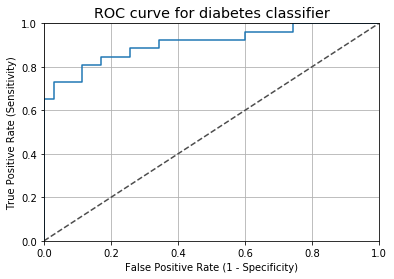

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

然后算AUC，根据经验：

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail


In [63]:
auc(fpr, tpr)

0.9076923076923078

结果很好

<a id='section4'></a>

# 对于模型的解释


**Permutation importance** 
这个是对变量重要性的一种解释工具，在model已经被fit了后，观察individual variables对准确性的影响。

这篇文章有大致的介绍**(https://blog.csdn.net/lz_peter/article/details/88654198)**

In [64]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

就排列而言，看起来最重要的因素是“可逆转缺陷”导致的贫血症。“达到最大心率”类型的高度重要性也是有道理的，因为这是患者在检查时的直接主观状态(而不是年龄，这是一个更普遍的因素)。

这里注意，在这个数据集里，也是结合了心脏病的相关domain knowledge进行判断。

然后看看**Partial Dependence Plot**，具体是什么看这个链接**(https://www.kaggle.com/dansbecker/partial-plots)**

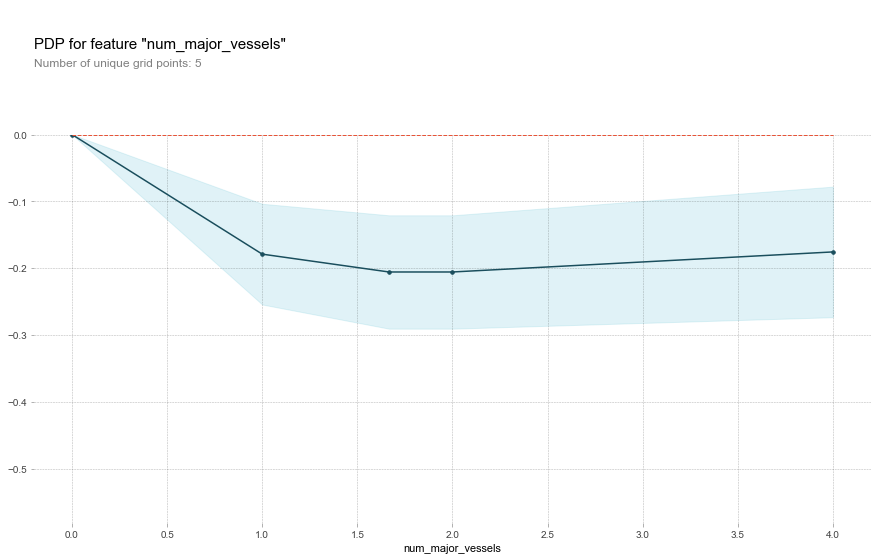

In [65]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

可以发现，随着主要血管数量的增加，患心脏病的概率降低。根据domain，这也是可以解释的，因为这说明更多的血液可以进入心脏。

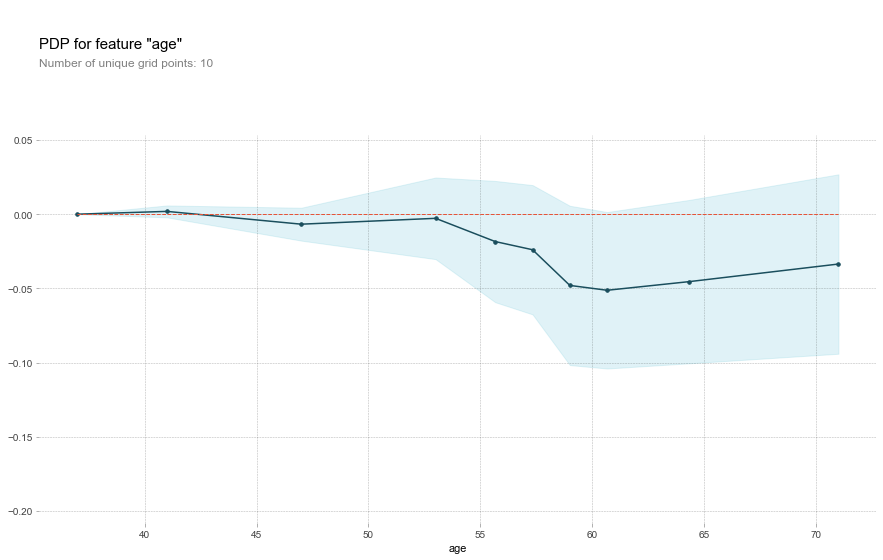

In [66]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

这个也算能解释。虽然图中年龄越高，患心脏病的几率越低，但是蓝色的置信区域表明这可能不是真的(红色基线在蓝色区域内)。

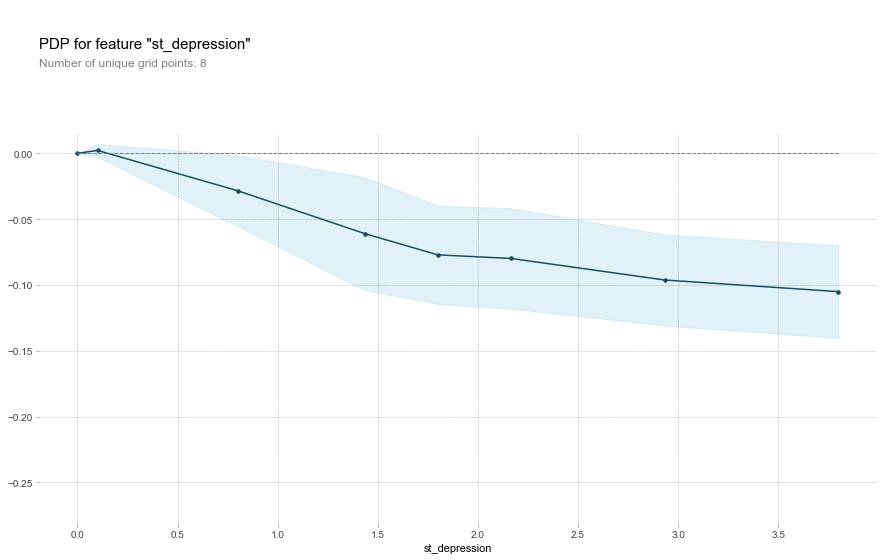

In [67]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

这个变量似乎表明这个值越高，患心脏病的概率就越高，但上面的图表显示的是相反的。也许重要的不仅仅是抑郁的程度，而是与斜率类型的相互作用?让我们用2D PDP检查一下，

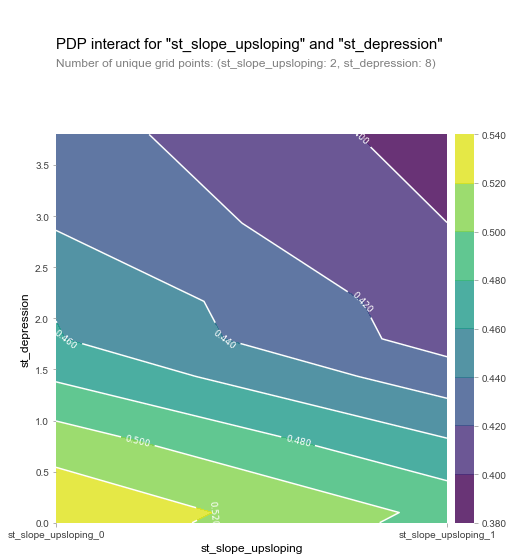

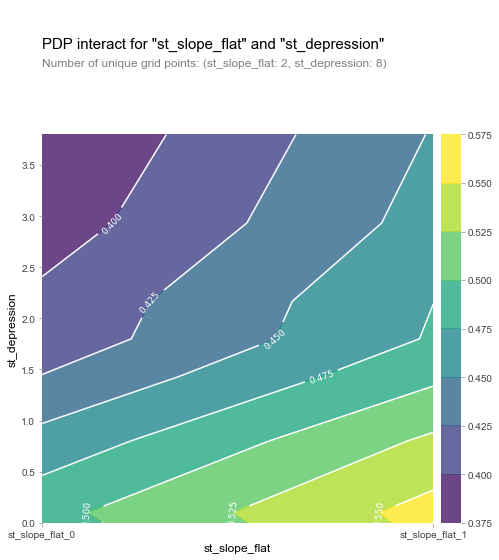

In [68]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

看起来低度抑郁症在两种情况下都很糟糕。

再看看shap。shap通过显示每行中每个变量值的影响，并将其与基线值进行比较。

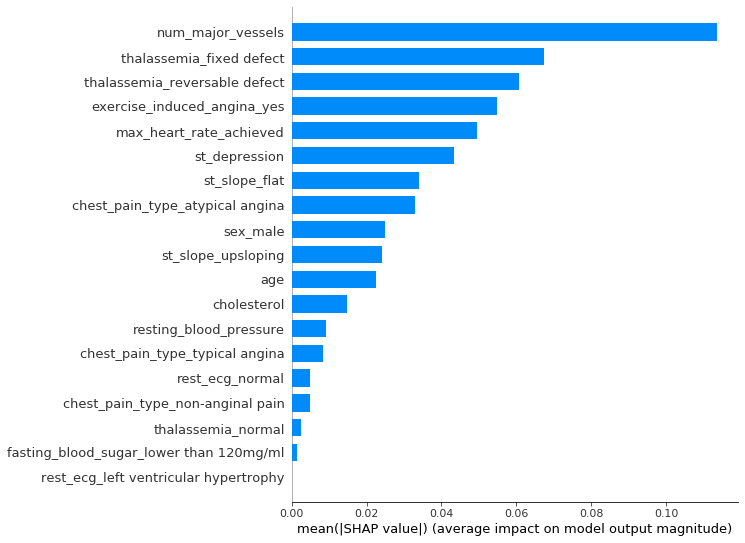

In [69]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

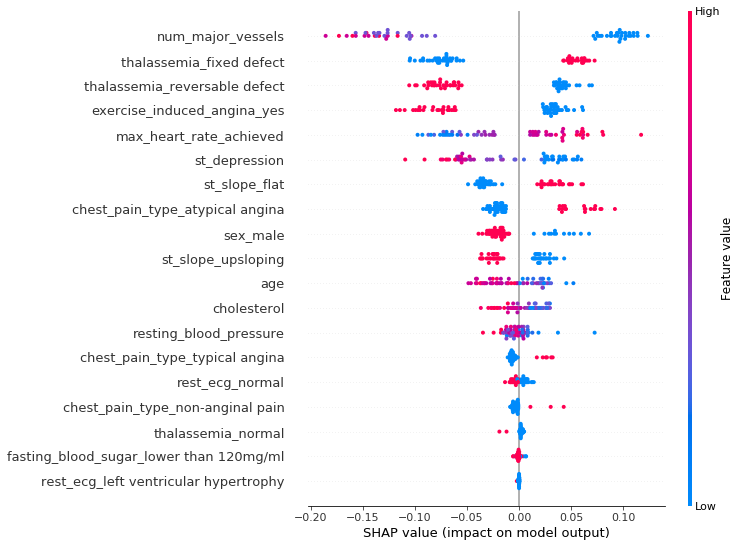

In [70]:
shap.summary_plot(shap_values[1], X_test)

major vessels division划分的数量非常清楚，低值是不好的(右边的蓝色)。地中海贫血“可逆转缺陷”的划分非常清楚(是=红=好，否=蓝=坏)。
你可以看到在许多其他变量中有一些清晰的分离。运动诱发心绞痛有明显的分离，虽然不像预期的那样，因为“no”(蓝色)增加了概率。另一个明显的例子是st_slope。它看起来是平的，这是一个不好的信号(右边的红色)。

这张图显示了50例样本患者的预测和影响因素。可以看出为什么每个人最后要么是红色(预测疾病)，要么是蓝色(预测没有疾病)。

In [78]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

<a id='section5'></a>